<a id='Homework'></a>
# Homework

Thoery (5 points):
- Complete theory questions in Google Form
- Take a look at all links 
- Read and analyze all theory `TODO`s. In this lecture they are highly important 

Practice (10-15 points):
- First Option (Easier) - Apply [Sentance Classification](#Sentance_Classification) approach to [CommonLit - Evaluate Student Summaries
](https://www.kaggle.com/competitions/commonlit-evaluate-student-summaries)
    - Max Base Points: 10
    - Tune `UniversalRNN`, maybe re-write it. Tune all other hyper-params
    - Try pre-trained word embeddings (do not use embeddings, trained with Transformer acrhitectures. We will cover it in the next lecture). Try Word2Vec, GloVe, FastText, Flair and etc.
    - Implement Cross-Validation
    - Make a submit to Kaggle
- Second Option (Harder) - Apply [Token Classification](#Token_Classification) approach to Location Detection task
    - Max Base Points: 15
    - Introduce fixes, mentioned in `TODO`s
    - Your model also have to handle russian language. Make sure to add `../data/mantis_analytics_location_detection/ru_geo_dataset.csv` (from https://www.kaggle.com/datasets/vladimirsydor/mantis-analytics-location-detection/data). Think about
        - New Validation
        - New Word Embeddings
        - Maybe separate models
    - Coming back to Lecture 3. F1 is the final production metric but it hardly depends on threshold. Maybe you can use some "soft" metric for model comparison ? 
    - Is the ML model formalized correctly? In my approach there are only 2 types of labels (O and LOC) but if you check [huggingface example](https://huggingface.co/learn/nlp-course/chapter7/2), there will be 3 labels (O; B-LOC and I-LOC)
    - Do we need additional post-processing ?
    - Tune `UniversalRNN`, maybe re-write it. Tune all other hyper-params
    - Try pre-trained word embeddings (do not use embeddings, trained with Transformer acrhitectures. We will cover it in the next lecture). Try Word2Vec, GloVe, FastText, Flair and etc.
    - Implement Cross-Validation
    - Upload best model + inference code on some cloud storage. So we can run it on our hidden test set. Make sure to open it ONLY for lectors
    - Additional points: first best test score - 25 points, second best test score - 15 points, third best test score - 10 points
- Third Option (Hardest). Do both first and second options
- Form will contain separate places for First and Second Options. Just put `-` for Option, which you have not choosen

<a id='homework_first_option'></a>
## First Option

What I did:
- Used fasttext word embeddings
- Rewrote UniversalRNN for CommonLit task
- Implemented GroupKFold with UniversalRNN
- Experimented with various hyperparameters (loss functions, model parameters, rnn types, batch sizes and so on)
- Tried Gradient Clipping and LR Scheduling in some experiments
- Private LB Score improved to **0.65** and Public LB to **0.593**! Public LB shows great correlation with local validation metric
- Read and analyzed TODOs in Lecture
<br>
<br>
Results using Tuned GRU + FastText embeddings:

![](images/submission_results.png)

### Imports

In [1]:
import re
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
os.environ["TOKENIZERS_PARALLELISM"]="true"
import torch
import fasttext
from fasttext.FastText import tokenize
import pandas as pd
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt

from tqdm import tqdm
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import GroupKFold
from gensim.models import Word2Vec, KeyedVectors
from matplotlib import pyplot as plt
from torch.utils.data import Dataset, DataLoader
from copy import deepcopy
from inspect import isfunction

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

### Load data

In [2]:
DATA_FOLDER = os.path.join('..', 'input')
COMMONLIT_DATA_FOLDER = os.path.join(DATA_FOLDER, 'commonlit-evaluate-student-summaries')
COMMONLIT_TRAIN_SUMMARIES_PATH = os.path.join(COMMONLIT_DATA_FOLDER, 'summaries_train.csv')
COMMONLIT_TRAIN_PROMPTS_PATH = os.path.join(COMMONLIT_DATA_FOLDER, 'prompts_train.csv')
COMMONLIT_TEST_SUMMARIES_PATH = os.path.join(COMMONLIT_DATA_FOLDER, 'summaries_test.csv')
COMMONLIT_TEST_PROMPTS_PATH = os.path.join(COMMONLIT_DATA_FOLDER, 'prompts_test.csv')

FASTTEXT_MODEL_PATH = os.path.join(DATA_FOLDER, 'fasttext-english-300', 'cc.en.300.bin')
GLOVE_MODEL_PATH = os.path.join('models', '')
WORD2VEC_MODEL_PATH = os.path.join('models', 'word2vec-GoogleNews-vectors-negative300.bin')

In [3]:
train_df = pd.read_csv(COMMONLIT_TRAIN_SUMMARIES_PATH)
train_pt_df = pd.read_csv(COMMONLIT_TRAIN_PROMPTS_PATH)
test_df = pd.read_csv(COMMONLIT_TEST_SUMMARIES_PATH)
test_pt_df = pd.read_csv(COMMONLIT_TEST_PROMPTS_PATH)

In [4]:
train_df.head()

,student_id,prompt_id,text,content,wording
0,000e8c3c7ddb,814d6b,The third wave was an experimentto see how peo...,0.205683,0.380538
1,0020ae56ffbf,ebad26,They would rub it up with soda to make the sme...,-0.548304,0.506755
2,004e978e639e,3b9047,"In Egypt, there were many occupations and soci...",3.128928,4.231226
3,005ab0199905,3b9047,The highest class was Pharaohs these people we...,-0.210614,-0.471415
4,0070c9e7af47,814d6b,The Third Wave developed rapidly because the ...,3.272894,3.219757


### EDA

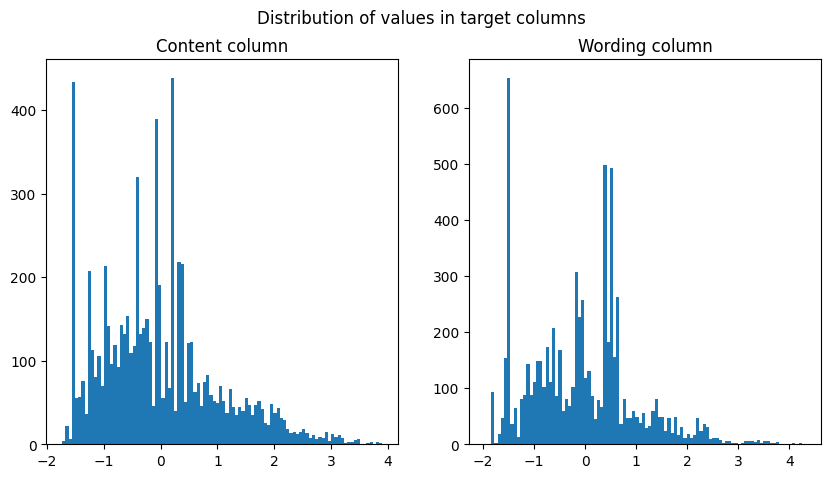

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Distribution of values in target columns')

axes[0].hist(train_df['content'], bins=100)
axes[0].set_title('Content column')
axes[1].hist(train_df['wording'], bins=100)
axes[1].set_title('Wording column')

plt.show();

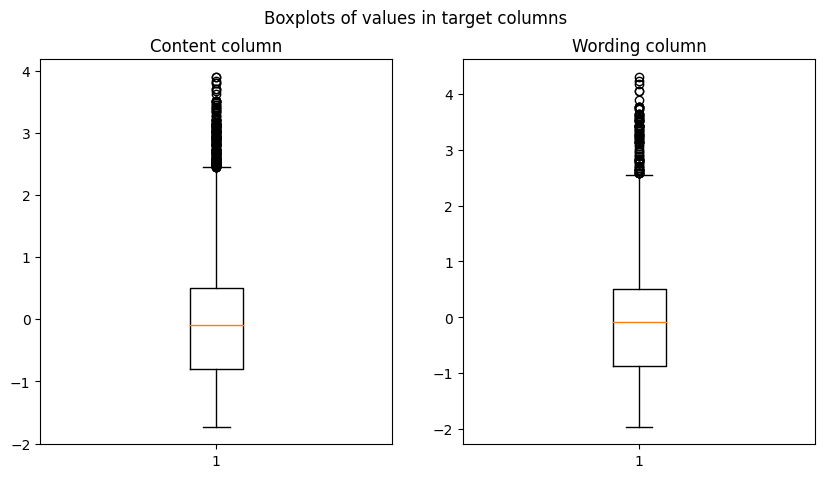

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Boxplots of values in target columns')

axes[0].boxplot(train_df['content'])
axes[0].set_title('Content column')
axes[1].boxplot(train_df['wording'])
axes[1].set_title('Wording column')

plt.show();

In [7]:
# Content column
q1 = np.percentile(train_df['content'], 25)
q3 = np.percentile(train_df['content'], 75)
iqr = q3 - q1
upper_bound = q3 + 1.5 * iqr
num_outliers_content = len(train_df['content'][train_df['content'] > upper_bound])

# Wording column
q1 = np.percentile(train_df['wording'], 25)
q3 = np.percentile(train_df['wording'], 75)
iqr = q3 - q1
upper_bound = q3 + 1.5 * iqr
num_outliers_wording = len(train_df['wording'][train_df['wording'] > upper_bound])

# Print results
print("Number of data points outside Q3+1.5IQR in Content column:", num_outliers_content)
print("Number of data points outside Q3+1.5IQR in Wording column:", num_outliers_wording)

Number of data points outside Q3+1.5IQR in Content column: 170
Number of data points outside Q3+1.5IQR in Wording column: 87


Number of statistical outliers is not high, but **we can test sensitive and non-sensitive to outliers loss functions**

### Preprocessing

In [8]:
train_df.sample(1).text.iloc[0]

"The Third Wave developed so quickly because of the convincing way he phrased his experiment and the actions he did to carry out his experiment. First, he started off with a motto that was easy to remember and catchy to say. He then took actions to enforce disciplines into his students, even making them use the salute to fellow students outside of class. The students complied because and because they were so easily molded to Ron Jones' ideas. It was ended because it became clear that the students were becoming too maliable and there was no point in doing the experiment anymore."

In [9]:
def preprocess(summary):
    # remove newline chars
    summary = re.sub('\n', ' ', summary)
    # remove dots
    summary = re.sub(r'\.', ' ', summary)
    # remove numbers, symbols, leave only characters
    summary = re.sub(r'[^a-zA-Z\s]', '', summary)
    # remove extra whitespaces
    summary = re.sub(r'\s+', ' ', summary)
    return summary

In [10]:
train_df['clean_text'] = train_df['text'].apply(lambda summary: preprocess(summary))

In [11]:
print('Before processing:')
train_df['text'].iloc[6]

Before processing:


'The Egyptian society is really different from other socicties I have learned about. As stated in the story in paragraph 6-13 it describes how people are in different places in the pyramid. Also tells us how people are treated and what they have to pay for things and the higher people have things more easy.All the classes have a different purpose which are important in their different wyas. This is how social classes are involved in there government.'

In [12]:
print('After processing:')
train_df['clean_text'].iloc[6]

After processing:


'The Egyptian society is really different from other socicties I have learned about As stated in the story in paragraph it describes how people are in different places in the pyramid Also tells us how people are treated and what they have to pay for things and the higher people have things more easy All the classes have a different purpose which are important in their different wyas This is how social classes are involved in there government '

#### Figure out max_length for texts

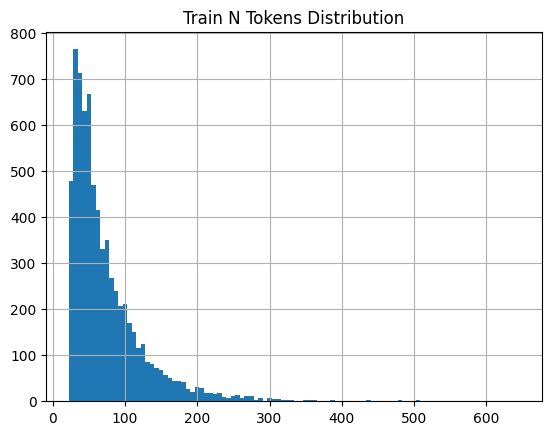

In [13]:
# Figure out max_length
train_n_tokens = train_df['clean_text'].apply(lambda x : len(tokenize(x)))

plt.title("Train N Tokens Distribution")
train_n_tokens.hist(bins=100)
plt.show()

In [14]:
print(f"0.8 Quantile of N tokens: {np.quantile(train_n_tokens, 0.8)}")
print(f"0.9 Quantile of N tokens: {np.quantile(train_n_tokens, 0.9)}")
print(f"0.95 Quantile of N tokens: {np.quantile(train_n_tokens, 0.95)}")

0.8 Quantile of N tokens: 103.0
0.9 Quantile of N tokens: 139.0
0.95 Quantile of N tokens: 176.0


In [15]:
print(f'Number of texts above {np.quantile(train_n_tokens, 0.95)} tokens: {sum(train_n_tokens > np.quantile(train_n_tokens, 0.95))}')

Number of texts above 176.0 tokens: 358


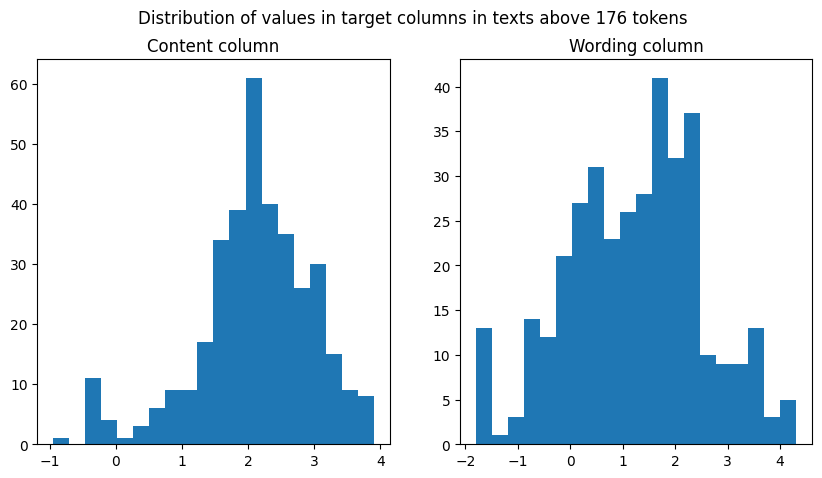

In [16]:
# Check 'content' and 'wording' distributions for text longer than 176 tokens

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle(f'Distribution of values in target columns in texts above {int(np.quantile(train_n_tokens, 0.95))} tokens')

index_list = train_n_tokens.loc[train_n_tokens > np.quantile(train_n_tokens, 0.95)].index

axes[0].hist(train_df['content'].iloc[index_list], bins=20)
axes[0].set_title('Content column')
axes[1].hist(train_df['wording'].iloc[index_list], bins=20)
axes[1].set_title('Wording column')

plt.show();

### Dataset creation

In [17]:
def load_embedding_model(model_type):
    if model_type == "fasttext":
        # can reduce dimensions using fasttext.util.reduce_model(ft, 100)
        model = fasttext.load_model(FASTTEXT_MODEL_PATH)
    elif model_type == "glove":
        model = KeyedVectors.load_word2vec_format(GLOVE_MODEL_PATH, binary=True)
    elif model_type == "word2vec":
        model = KeyedVectors.load_word2vec_format(WORD2VEC_MODEL_PATH, binary=True)
    else:
        raise ValueError("Invalid embedding model. Supported models are: fasttext, glove, word2vec")
    return model


class TextDataset(Dataset):
    def __init__(self, text_list, labels, max_length, model, model_type):
        self.text_list = text_list
        self.labels = labels
        self.max_length = max_length
        self.pad_token = '<pad>'
        self.trim_policy = 'first'
        self.model_type = model_type
        self.model = model

    def __len__(self):
        return len(self.text_list)

    def __getitem__(self, idx):
        text = self.text_list[idx]
        text = tokenize(text)
        text = self.process_text_sequence(text)
        text_embedding = self.get_text_embedding(text)
        labels = self.labels[idx]
        return text_embedding, torch.from_numpy(labels).float()

    def process_text_sequence(self, input):
        """
        Pads or truncates text sequences to a certain value
        """
        if len(input) < self.max_length:
            return input + [self.pad_token] * (self.max_length - len(input))
        elif len(input) > self.max_length:
            if self.trim_policy == "random":
                start = np.random.randint(0, len(input) - self.max_length)
            elif self.trim_policy == "first":
                start = 0
            return input[start : start + self.max_length]
        else: 
            return input

    def get_text_embedding(self, text):
        """
        Generates embeddings for each word in the text sequence
        """
        if self.model_type == "fasttext":
            # fasttext can handle out-of-vocabulary words that's why we don't need to check for them
            word_embeddings = [self.model.get_word_vector(word) for word in text]
        else:
            word_embeddings = [self.model[word] if word in self.model else np.zeros(self.model.vector_size) for word in words]
        return torch.tensor(np.array(word_embeddings), dtype=torch.float32)

### Modeling

In [18]:
class RNNRegressor(nn.Module):
    def __init__(self, rnn_type, input_size, hidden_size, num_layers, bidirectional, dropout_rate, average_type):
        super().__init__()
        if not average_type in ["mean", "last"]:
            raise ValueError(f"Average_type `{average_type}` is not supported")
        self.average_type = average_type
        self.rnn = rnn_type(input_size, hidden_size, num_layers, batch_first=True, bidirectional=bidirectional)
        self.fc_content = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_size * 2 if bidirectional else hidden_size, 1)
        )
        self.fc_wording = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_size * 2 if bidirectional else hidden_size, 1)
        )

    def forward(self, x):
        out, _ = self.rnn(x)
        
        if self.average_type == "mean":
            out = out.mean(1)
        elif self.average_type == "last":
            out = out[:,-1,:]
            
        out_content, out_wording = self.fc_content(out), self.fc_wording(out)
        
        return torch.cat((out_content, out_wording), dim=1)

Use CommonLit competition evaluation metric MCRMSE

In [19]:
def compute_mcrmse(targets, predictions):
    content_rmse = torch.sqrt(torch.mean((targets[:, 0] - predictions[:, 0]) ** 2))
    wording_rmse = torch.sqrt(torch.mean((targets[:, 1] - predictions[:, 1]) ** 2))
    mcrmse = torch.mean(torch.cat((content_rmse.reshape(-1), wording_rmse.reshape(-1)), dim=0))
    return mcrmse

def compute_mcrmse_numpy(targets, predictions):
    content_rmse = np.sqrt(np.mean((targets[:, 0] - predictions[:, 0]) ** 2))
    wording_rmse = np.sqrt(np.mean((targets[:, 1] - predictions[:, 1]) ** 2))
    mcrmse = np.mean(np.concatenate((content_rmse.reshape(-1), wording_rmse.reshape(-1)), axis=0))
    return mcrmse

In [20]:
loss_functions = {
    'mse': nn.MSELoss(),
    'mae': nn.L1Loss(),
    'smooth_l1': nn.SmoothL1Loss(),
    'huber': nn.HuberLoss(delta=1.0),
    'mcrmse': compute_mcrmse
}

In [68]:
def torch_loop(
    model,
    criterion,
    optimizer,
    dataloader,
    device,
    mode="train"
):
    if mode == "train":
        model.train()
    else:
        model.eval()
        
    all_outputs = []
    all_losses = []
    all_targets = []
    
    with torch.inference_mode(mode=(mode != "train")):
        for text, labels in tqdm(dataloader):
            text, labels = text.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            if mode == "train":
                optimizer.zero_grad()
            outputs = model(text)
            
            if isfunction(criterion):
                loss = criterion(outputs, labels)
            else:    
                loss_content = criterion(outputs[:, 0], labels[:, 0])
                loss_wording = criterion(outputs[:, 1], labels[:, 1])
                loss = loss_content + loss_wording
                
            if mode == "train":
                loss.backward()
#                 torch.nn.utils.clip_grad_norm_(model.parameters(), 0.9)
                optimizer.step()
                
            # Accumulate stats
            all_outputs.append(outputs.detach().cpu().numpy())
            all_losses.append(loss.item())
            all_targets.append(labels.detach().cpu().numpy())
    all_outputs = np.concatenate(all_outputs)
    # all_losses = np.concatenate(all_losses)
    all_targets = np.concatenate(all_targets)
    
    return all_outputs, all_losses, all_targets

In [70]:
# Model parameters
input_size = 300
hidden_size = 300
num_layers = 1
bidirectional = False
dropout_rate = 0.3
rnn_type = nn.GRU
average_type = 'last'

max_length = 176

# Training parameters
num_epochs = 30
batch_size = 8
learning_rate = 0.001

# Used to store all information (losses, predictions, targets, metrics) of a certain fold in GroupKFold
fold_data = {
    'fold_1': None,
    'fold_2': None,
    'fold_3': None,
    'fold_4': None,
}

In [24]:
model_type = 'fasttext'
embedding_model = load_embedding_model(model_type)

In [71]:
cv = GroupKFold(n_splits=4)
groups = train_df['prompt_id']
for index, (train_idx, test_idx) in enumerate(cv.split(train_df['clean_text'], train_df[['content', 'wording']], groups=groups), start=1):
    # Store fold-specific data
    train_all_epoch_outputs = []
    train_all_epoch_losses = []
    train_all_epoch_targets = []
    valid_all_epoch_outputs = []
    valid_all_epoch_losses = []
    valid_all_epoch_targets = []
    valid_metrics = []
    train_metrics = []
    best_metric = np.inf
    best_model_state_dict = None
    
    print(f'Fold [{index}/{4}]')
#     if index != 3:
#         print(f'Skipped Fold [{index}/{4}]')
#         continue
    
    # Split into train and validation
    X_train, X_test = train_df['clean_text'].iloc[train_idx].to_list(), train_df['clean_text'].iloc[test_idx].to_list()
    y_train, y_test = train_df[['content', 'wording']].iloc[train_idx].to_numpy(), \
        train_df[['content', 'wording']].iloc[test_idx].to_numpy()

    # Create datasets and dataloaders
    train_dataset = TextDataset(X_train, y_train, max_length, embedding_model, model_type)
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, drop_last=True, shuffle=True, pin_memory=True, num_workers=4)
    valid_dataset = TextDataset(X_test, y_test, max_length, embedding_model, model_type)
    valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, drop_last=False, shuffle=False, pin_memory=True, num_workers=4)

    # Create model and perform training and validation
    model = RNNRegressor(rnn_type, input_size, hidden_size, num_layers, bidirectional, dropout_rate, average_type).to(device)
    criterion = loss_functions.get('huber')
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2, factor=0.5, min_lr=1e-6, mode='min', verbose=True)
    for epoch in range(1, num_epochs + 1):
        print(f'Epoch [{epoch}/{num_epochs}]')

        # Training phase
        all_outputs_train, all_losses_train, all_targets_train = torch_loop(
            model, criterion, optimizer, train_dataloader, device, 'train'
        )
        train_metric = compute_mcrmse_numpy(
            all_targets_train, 
            all_outputs_train
        )
        print("Train metric:", train_metric)
        print("Train loss:", np.array(all_losses_train).mean())

        # Validation phase
        all_outputs_valid, all_losses_valid, all_targets_valid = torch_loop(
            model, criterion, optimizer, valid_dataloader, device, 'valid'
        )
        valid_metric = compute_mcrmse_numpy(
            all_targets_valid, 
            all_outputs_valid
        )
        print("Validation metric:", valid_metric)
        print("Validation loss:", np.array(all_losses_valid).mean())

        # Scheduler update
#         scheduler.step(valid_metric)
        # Save best model
        if valid_metric < best_metric:
            best_metric = valid_metric
            best_model_state_dict = deepcopy(model.state_dict())
        # Accumulate all stats  
        train_all_epoch_outputs.append(all_outputs_train)
        train_all_epoch_losses.append(all_losses_train)
        train_all_epoch_targets.append(all_targets_train)
        valid_all_epoch_outputs.append(all_outputs_valid)
        valid_all_epoch_losses.append(all_losses_valid)
        valid_all_epoch_targets.append(all_targets_valid)
        valid_metrics.append(valid_metric)
        train_metrics.append(train_metric)
        
        print('-' * 40)

    fold_data[f'fold_{index}'] = {
        'train_all_epoch_outputs': train_all_epoch_outputs,
        'train_all_epoch_losses': train_all_epoch_losses,
        'train_all_epoch_targets': train_all_epoch_targets,
        'valid_all_epoch_outputs': valid_all_epoch_outputs,
        'valid_all_epoch_losses': valid_all_epoch_losses,
        'valid_all_epoch_targets': valid_all_epoch_targets,
        'valid_metrics': valid_metrics,
        'train_metrics': train_metrics,
        'best_metric': best_metric,
        'best_model_state_dict': best_model_state_dict
    }

Fold [1/4]
Epoch [1/30]


100%|██████████| 638/638 [00:07<00:00, 87.82it/s] 


Train metric: 1.0575985
Train loss: 0.9298502471659998


100%|██████████| 258/258 [00:02<00:00, 92.62it/s] 


Validation metric: 1.0167735
Validation loss: 0.8399431345074676
----------------------------------------
Epoch [2/30]


100%|██████████| 638/638 [00:07<00:00, 87.60it/s] 


Train metric: 1.0768565
Train loss: 0.9504025770485588


100%|██████████| 258/258 [00:02<00:00, 91.79it/s] 


Validation metric: 0.9879214
Validation loss: 0.808105135033297
----------------------------------------
Epoch [3/30]


100%|██████████| 638/638 [00:06<00:00, 92.60it/s] 


Train metric: 1.0237889
Train loss: 0.8779234407837488


100%|██████████| 258/258 [00:02<00:00, 92.06it/s] 


Validation metric: 0.96326023
Validation loss: 0.7920363377924113
----------------------------------------
Epoch [4/30]


100%|██████████| 638/638 [00:07<00:00, 90.56it/s] 


Train metric: 1.0059042
Train loss: 0.8542050486634891


100%|██████████| 258/258 [00:03<00:00, 85.36it/s] 


Validation metric: 0.9833354
Validation loss: 0.8263635560292606
----------------------------------------
Epoch [5/30]


100%|██████████| 638/638 [00:06<00:00, 92.68it/s] 


Train metric: 1.0019858
Train loss: 0.8473638186120315


100%|██████████| 258/258 [00:02<00:00, 93.00it/s] 


Validation metric: 0.9598359
Validation loss: 0.7669890353730483
----------------------------------------
Epoch [6/30]


100%|██████████| 638/638 [00:06<00:00, 93.48it/s] 


Train metric: 0.9985646
Train loss: 0.8446659941144498


100%|██████████| 258/258 [00:02<00:00, 94.44it/s] 


Validation metric: 0.9644748
Validation loss: 0.7830259991708652
----------------------------------------
Epoch [7/30]


100%|██████████| 638/638 [00:06<00:00, 93.55it/s] 


Train metric: 0.9992461
Train loss: 0.8459207121761615


100%|██████████| 258/258 [00:02<00:00, 88.84it/s] 


Validation metric: 0.95671535
Validation loss: 0.7949538678508397
----------------------------------------
Epoch [8/30]


100%|██████████| 638/638 [00:06<00:00, 91.50it/s] 


Train metric: 1.000404
Train loss: 0.8497000555726801


100%|██████████| 258/258 [00:02<00:00, 91.70it/s] 


Validation metric: 0.94742286
Validation loss: 0.7770182466091111
----------------------------------------
Epoch [9/30]


100%|██████████| 638/638 [00:06<00:00, 93.90it/s] 


Train metric: 1.0264045
Train loss: 0.8840425421358276


100%|██████████| 258/258 [00:02<00:00, 93.14it/s] 


Validation metric: 0.9877282
Validation loss: 0.8345988830623701
----------------------------------------
Epoch [10/30]


100%|██████████| 638/638 [00:06<00:00, 93.05it/s] 


Train metric: 1.0310588
Train loss: 0.8922771034663


100%|██████████| 258/258 [00:02<00:00, 91.68it/s] 


Validation metric: 0.9497595
Validation loss: 0.7812491203116816
----------------------------------------
Epoch [11/30]


100%|██████████| 638/638 [00:07<00:00, 88.98it/s] 


Train metric: 1.0030926
Train loss: 0.8535927369209666


100%|██████████| 258/258 [00:02<00:00, 93.44it/s] 


Validation metric: 1.4291775
Validation loss: 1.4369509324662446
----------------------------------------
Epoch [12/30]


100%|██████████| 638/638 [00:06<00:00, 94.52it/s] 


Train metric: 1.0491042
Train loss: 0.9207596088464731


100%|██████████| 258/258 [00:02<00:00, 92.50it/s] 


Validation metric: 0.9621894
Validation loss: 0.7947812629069468
----------------------------------------
Epoch [13/30]


100%|██████████| 638/638 [00:06<00:00, 94.37it/s] 


Train metric: 1.0178524
Train loss: 0.8790962021786217


100%|██████████| 258/258 [00:02<00:00, 93.08it/s] 


Validation metric: 0.95071447
Validation loss: 0.7930314219159673
----------------------------------------
Epoch [14/30]


100%|██████████| 638/638 [00:07<00:00, 88.76it/s] 


Train metric: 1.0489132
Train loss: 0.9200947886116826


100%|██████████| 258/258 [00:02<00:00, 93.53it/s] 


Validation metric: 0.95596915
Validation loss: 0.7791996415733367
----------------------------------------
Epoch [15/30]


100%|██████████| 638/638 [00:06<00:00, 92.76it/s] 


Train metric: 1.0101979
Train loss: 0.8641840933725752


100%|██████████| 258/258 [00:02<00:00, 91.64it/s] 


Validation metric: 0.95959365
Validation loss: 0.798418804194576
----------------------------------------
Epoch [16/30]


100%|██████████| 638/638 [00:06<00:00, 94.22it/s] 


Train metric: 1.009981
Train loss: 0.8661742947972306


100%|██████████| 258/258 [00:02<00:00, 93.71it/s] 


Validation metric: 0.9431768
Validation loss: 0.7710087178058402
----------------------------------------
Epoch [17/30]


100%|██████████| 638/638 [00:06<00:00, 94.68it/s] 


Train metric: 0.99707174
Train loss: 0.8461529690083291


100%|██████████| 258/258 [00:03<00:00, 81.33it/s] 


Validation metric: 0.9587058
Validation loss: 0.799279225311538
----------------------------------------
Epoch [18/30]


100%|██████████| 638/638 [00:06<00:00, 94.20it/s] 


Train metric: 1.0479145
Train loss: 0.9166297546608321


100%|██████████| 638/638 [00:06<00:00, 94.25it/s] 


Train metric: 1.0523579
Train loss: 0.9200449251923067


100%|██████████| 258/258 [00:02<00:00, 92.57it/s] 


Validation metric: 1.0360215
Validation loss: 0.8901292168816854
----------------------------------------
Epoch [20/30]


100%|██████████| 638/638 [00:06<00:00, 94.04it/s] 


Train metric: 1.0218358
Train loss: 0.8847641097177346


100%|██████████| 258/258 [00:02<00:00, 91.48it/s] 


Validation metric: 0.9312241
Validation loss: 0.7647996798966282
----------------------------------------
Epoch [21/30]


100%|██████████| 638/638 [00:07<00:00, 88.60it/s] 


Train metric: 1.0084956
Train loss: 0.8644450692967935


100%|██████████| 258/258 [00:02<00:00, 92.13it/s] 


Validation metric: 0.9619999
Validation loss: 0.7814894261401754
----------------------------------------
Epoch [22/30]


100%|██████████| 638/638 [00:06<00:00, 94.49it/s] 


Train metric: 1.0159144
Train loss: 0.8707515362848682


100%|██████████| 258/258 [00:02<00:00, 92.93it/s] 


Validation metric: 1.013885
Validation loss: 0.8462803128731343
----------------------------------------
Epoch [23/30]


100%|██████████| 638/638 [00:06<00:00, 93.99it/s] 


Train metric: 1.0456108
Train loss: 0.9146372534591576


100%|██████████| 258/258 [00:02<00:00, 93.14it/s] 


Validation metric: 0.9569981
Validation loss: 0.7716568515513295
----------------------------------------
Epoch [24/30]


100%|██████████| 638/638 [00:07<00:00, 89.86it/s] 


Train metric: 1.0383964
Train loss: 0.9041839555886846


100%|██████████| 258/258 [00:02<00:00, 93.13it/s] 


Validation metric: 0.9508804
Validation loss: 0.7827885595634002
----------------------------------------
Epoch [25/30]


100%|██████████| 638/638 [00:06<00:00, 94.63it/s] 


Train metric: 1.022415
Train loss: 0.8851088172169315


100%|██████████| 258/258 [00:02<00:00, 93.61it/s] 


Validation metric: 0.9370407
Validation loss: 0.756770416747692
----------------------------------------
Epoch [26/30]


100%|██████████| 638/638 [00:06<00:00, 93.93it/s] 


Train metric: 1.0189267
Train loss: 0.8779145301696275


100%|██████████| 258/258 [00:02<00:00, 93.17it/s] 


Validation metric: 0.9446279
Validation loss: 0.7605919363193734
----------------------------------------
Epoch [27/30]


100%|██████████| 638/638 [00:06<00:00, 92.88it/s] 


Train metric: 1.0345225
Train loss: 0.8990885326434452


100%|██████████| 258/258 [00:03<00:00, 82.66it/s] 


Validation metric: 0.9987495
Validation loss: 0.8756905629537827
----------------------------------------
Epoch [28/30]


100%|██████████| 638/638 [00:06<00:00, 93.65it/s] 


Train metric: 1.014584
Train loss: 0.8706774281390408


100%|██████████| 258/258 [00:02<00:00, 91.82it/s] 


Validation metric: 0.9471051
Validation loss: 0.7882502014900363
----------------------------------------
Epoch [29/30]


100%|██████████| 638/638 [00:06<00:00, 95.00it/s] 


Train metric: 1.0364289
Train loss: 0.9044836841780564


100%|██████████| 258/258 [00:02<00:00, 92.12it/s] 


Validation metric: 1.0006671
Validation loss: 0.8771859472689703
----------------------------------------
Epoch [30/30]


100%|██████████| 638/638 [00:06<00:00, 94.65it/s] 


Train metric: 1.0344311
Train loss: 0.9007140214914064


100%|██████████| 258/258 [00:02<00:00, 92.83it/s] 


Validation metric: 0.960008
Validation loss: 0.7829912799850914
----------------------------------------
Fold [2/4]
Epoch [1/30]


100%|██████████| 644/644 [00:07<00:00, 89.85it/s] 


Train metric: 1.0011317
Train loss: 0.841721821067311


100%|██████████| 252/252 [00:02<00:00, 92.92it/s] 


Validation metric: 0.942121
Validation loss: 0.7836891895248776
----------------------------------------
Epoch [2/30]


100%|██████████| 644/644 [00:06<00:00, 94.18it/s] 


Train metric: 1.0529668
Train loss: 0.9145766123203758


100%|██████████| 252/252 [00:02<00:00, 90.18it/s] 


Validation metric: 0.97056496
Validation loss: 0.8335799503894079
----------------------------------------
Epoch [3/30]


100%|██████████| 644/644 [00:06<00:00, 94.10it/s] 


Train metric: 1.0684055
Train loss: 0.932463543362314


100%|██████████| 252/252 [00:02<00:00, 93.36it/s] 


Validation metric: 1.1813884
Validation loss: 1.0980234388557693
----------------------------------------
Epoch [4/30]


100%|██████████| 644/644 [00:07<00:00, 89.11it/s] 


Train metric: 1.0414131
Train loss: 0.8947014721191447


100%|██████████| 252/252 [00:02<00:00, 94.74it/s] 


Validation metric: 0.9876808
Validation loss: 0.8581687841150496
----------------------------------------
Epoch [5/30]


100%|██████████| 644/644 [00:06<00:00, 94.16it/s] 


Train metric: 1.0526667
Train loss: 0.910802587704814


100%|██████████| 252/252 [00:02<00:00, 92.07it/s] 


Validation metric: 1.0320268
Validation loss: 0.9017533624456042
----------------------------------------
Epoch [6/30]


100%|██████████| 644/644 [00:06<00:00, 93.83it/s] 


Train metric: 1.0539758
Train loss: 0.9090528420363524


100%|██████████| 252/252 [00:02<00:00, 92.81it/s] 


Validation metric: 0.9810507
Validation loss: 0.8355097890136733
----------------------------------------
Epoch [7/30]


100%|██████████| 644/644 [00:07<00:00, 89.89it/s] 


Train metric: 1.0252559
Train loss: 0.8732622250312974


100%|██████████| 252/252 [00:02<00:00, 94.51it/s] 


Validation metric: 0.94628525
Validation loss: 0.7948916841830526
----------------------------------------
Epoch [8/30]


100%|██████████| 644/644 [00:06<00:00, 95.12it/s] 


Train metric: 1.0695305
Train loss: 0.9276759082115955


100%|██████████| 252/252 [00:02<00:00, 92.76it/s] 


Validation metric: 1.035399
Validation loss: 0.9259661061777955
----------------------------------------
Epoch [9/30]


100%|██████████| 644/644 [00:06<00:00, 93.92it/s] 


Train metric: 1.0677574
Train loss: 0.9239961286972028


100%|██████████| 252/252 [00:02<00:00, 91.91it/s] 


Validation metric: 1.0075383
Validation loss: 0.8771624378268681
----------------------------------------
Epoch [10/30]


100%|██████████| 644/644 [00:06<00:00, 93.94it/s] 


Train metric: 1.0414133
Train loss: 0.8945519923932433


100%|██████████| 252/252 [00:03<00:00, 81.60it/s] 


Validation metric: 0.95391613
Validation loss: 0.8143419366743829
----------------------------------------
Epoch [11/30]


100%|██████████| 644/644 [00:06<00:00, 94.55it/s] 


Train metric: 1.0198724
Train loss: 0.8661771610564326


100%|██████████| 252/252 [00:02<00:00, 92.25it/s] 


Validation metric: 0.9485842
Validation loss: 0.803858567561422
----------------------------------------
Epoch [12/30]


100%|██████████| 644/644 [00:06<00:00, 94.90it/s] 


Train metric: 1.0386925
Train loss: 0.8960700694541013


100%|██████████| 252/252 [00:02<00:00, 91.21it/s] 


Validation metric: 0.9910768
Validation loss: 0.8658761662386713
----------------------------------------
Epoch [13/30]


100%|██████████| 644/644 [00:06<00:00, 93.70it/s] 


Train metric: 1.0587924
Train loss: 0.9153822697930455


100%|██████████| 252/252 [00:02<00:00, 92.27it/s] 


Validation metric: 0.9689977
Validation loss: 0.8254752651093498
----------------------------------------
Epoch [14/30]


100%|██████████| 644/644 [00:07<00:00, 89.16it/s] 


Train metric: 1.0303423
Train loss: 0.8818910550673186


100%|██████████| 252/252 [00:02<00:00, 90.43it/s] 


Validation metric: 1.030935
Validation loss: 0.9260078634298037
----------------------------------------
Epoch [15/30]


100%|██████████| 644/644 [00:06<00:00, 94.04it/s] 


Train metric: 1.034526
Train loss: 0.8878450501039161


100%|██████████| 252/252 [00:02<00:00, 93.09it/s] 


Validation metric: 0.92434716
Validation loss: 0.7630420340195535
----------------------------------------
Epoch [16/30]


100%|██████████| 644/644 [00:06<00:00, 93.76it/s] 


Train metric: 1.0058242
Train loss: 0.8485040735476506


100%|██████████| 252/252 [00:02<00:00, 90.91it/s] 


Validation metric: 1.0026761
Validation loss: 0.8607433152104181
----------------------------------------
Epoch [17/30]


100%|██████████| 644/644 [00:07<00:00, 89.69it/s] 


Train metric: 1.0153402
Train loss: 0.8645179153460524


100%|██████████| 252/252 [00:02<00:00, 92.67it/s] 


Validation metric: 0.9246948
Validation loss: 0.7642588806412522
----------------------------------------
Epoch [18/30]


100%|██████████| 644/644 [00:06<00:00, 93.97it/s] 


Train metric: 1.0146439
Train loss: 0.8627528262712201


100%|██████████| 252/252 [00:02<00:00, 91.64it/s] 


Validation metric: 0.96175647
Validation loss: 0.8154732853410736
----------------------------------------
Epoch [19/30]


100%|██████████| 644/644 [00:06<00:00, 94.42it/s] 


Train metric: 1.0180361
Train loss: 0.8653370293771258


100%|██████████| 252/252 [00:02<00:00, 93.68it/s] 


Validation metric: 0.962589
Validation loss: 0.8238287701729744
----------------------------------------
Epoch [20/30]


100%|██████████| 644/644 [00:06<00:00, 94.48it/s] 


Train metric: 1.014555
Train loss: 0.8626649416983128


100%|██████████| 252/252 [00:03<00:00, 80.18it/s] 


Validation metric: 1.0115571
Validation loss: 0.891307862386817
----------------------------------------
Epoch [21/30]


100%|██████████| 644/644 [00:06<00:00, 94.22it/s] 


Train metric: 1.0075248
Train loss: 0.8541758406837905


100%|██████████| 252/252 [00:02<00:00, 92.78it/s] 


Validation metric: 0.97601783
Validation loss: 0.832299457892539
----------------------------------------
Epoch [22/30]


100%|██████████| 644/644 [00:06<00:00, 93.85it/s] 


Train metric: 1.0125217
Train loss: 0.8603294444565447


100%|██████████| 252/252 [00:02<00:00, 89.56it/s] 


Validation metric: 0.99635863
Validation loss: 0.868045737700803
----------------------------------------
Epoch [23/30]


100%|██████████| 644/644 [00:06<00:00, 93.49it/s] 


Train metric: 1.0196772
Train loss: 0.8733412354305294


100%|██████████| 252/252 [00:02<00:00, 92.03it/s] 


Validation metric: 0.98372346
Validation loss: 0.8530072794547157
----------------------------------------
Epoch [24/30]


100%|██████████| 644/644 [00:07<00:00, 90.38it/s] 


Train metric: 1.0104405
Train loss: 0.8568605386090945


100%|██████████| 252/252 [00:02<00:00, 90.56it/s] 


Validation metric: 1.0456172
Validation loss: 0.915306750625845
----------------------------------------
Epoch [25/30]


100%|██████████| 644/644 [00:06<00:00, 94.64it/s] 


Train metric: 1.0350255
Train loss: 0.8905914583191368


100%|██████████| 252/252 [00:02<00:00, 91.16it/s] 


Validation metric: 1.03696
Validation loss: 0.9339328056999615
----------------------------------------
Epoch [26/30]


100%|██████████| 644/644 [00:06<00:00, 94.54it/s] 


Train metric: 1.0163468
Train loss: 0.8649535708083129


100%|██████████| 252/252 [00:02<00:00, 90.74it/s] 


Validation metric: 0.96661973
Validation loss: 0.8300574432526316
----------------------------------------
Epoch [27/30]


100%|██████████| 644/644 [00:07<00:00, 90.30it/s] 


Train metric: 1.0104859
Train loss: 0.8565674464200964


100%|██████████| 252/252 [00:02<00:00, 92.37it/s] 


Validation metric: 1.0337112
Validation loss: 0.9086402033766111
----------------------------------------
Epoch [28/30]


100%|██████████| 644/644 [00:06<00:00, 95.02it/s] 


Train metric: 1.038613
Train loss: 0.89288051958595


100%|██████████| 252/252 [00:02<00:00, 91.83it/s] 


Validation metric: 0.98126173
Validation loss: 0.8520154805765265
----------------------------------------
Epoch [29/30]


100%|██████████| 644/644 [00:06<00:00, 94.44it/s] 


Train metric: 1.0165409
Train loss: 0.8669035094124931


100%|██████████| 252/252 [00:02<00:00, 90.39it/s] 


Validation metric: 0.9303282
Validation loss: 0.7705958065769029
----------------------------------------
Epoch [30/30]


100%|██████████| 644/644 [00:06<00:00, 94.32it/s] 


Train metric: 1.0144823
Train loss: 0.8644568993252997


100%|██████████| 252/252 [00:02<00:00, 88.67it/s] 


Validation metric: 0.9163251
Validation loss: 0.7551703397480268
----------------------------------------
Fold [3/4]
Epoch [1/30]


100%|██████████| 646/646 [00:06<00:00, 93.98it/s] 


Train metric: 1.0217863
Train loss: 0.8758489772354486


100%|██████████| 250/250 [00:02<00:00, 93.89it/s] 


Validation metric: 0.968912
Validation loss: 0.8298261554241181
----------------------------------------
Epoch [2/30]


100%|██████████| 646/646 [00:06<00:00, 94.05it/s] 


Train metric: 1.1216784
Train loss: 1.0055279020369976


100%|██████████| 250/250 [00:02<00:00, 93.24it/s] 


Validation metric: 1.0003829
Validation loss: 0.882525358915329
----------------------------------------
Epoch [3/30]


100%|██████████| 646/646 [00:06<00:00, 94.23it/s] 


Train metric: 1.0704273
Train loss: 0.9401374346239278


100%|██████████| 250/250 [00:02<00:00, 89.42it/s] 


Validation metric: 0.9595146
Validation loss: 0.8239754830002785
----------------------------------------
Epoch [4/30]


100%|██████████| 646/646 [00:07<00:00, 91.04it/s] 


Train metric: 1.0377972
Train loss: 0.9006052798946207


100%|██████████| 250/250 [00:02<00:00, 93.77it/s] 


Validation metric: 0.9125484
Validation loss: 0.7418861184120178
----------------------------------------
Epoch [5/30]


100%|██████████| 646/646 [00:06<00:00, 92.67it/s] 


Train metric: 1.0305816
Train loss: 0.8903932970928334


100%|██████████| 250/250 [00:02<00:00, 94.09it/s] 


Validation metric: 0.89397335
Validation loss: 0.7195336742401123
----------------------------------------
Epoch [6/30]


100%|██████████| 646/646 [00:06<00:00, 94.72it/s] 


Train metric: 1.021682
Train loss: 0.8768047148321435


100%|██████████| 250/250 [00:02<00:00, 94.35it/s] 


Validation metric: 0.8928312
Validation loss: 0.7167318178415298
----------------------------------------
Epoch [7/30]


100%|██████████| 646/646 [00:07<00:00, 88.88it/s] 


Train metric: 1.0169988
Train loss: 0.8709767261295127


100%|██████████| 250/250 [00:02<00:00, 92.46it/s] 


Validation metric: 0.90001106
Validation loss: 0.7310384647250175
----------------------------------------
Epoch [8/30]


100%|██████████| 646/646 [00:06<00:00, 94.43it/s] 


Train metric: 1.0144333
Train loss: 0.8659696035756046


100%|██████████| 250/250 [00:02<00:00, 92.31it/s] 


Validation metric: 0.9461509
Validation loss: 0.800955649793148
----------------------------------------
Epoch [9/30]


100%|██████████| 646/646 [00:06<00:00, 94.25it/s] 


Train metric: 1.0139811
Train loss: 0.8655646619828123


100%|██████████| 250/250 [00:02<00:00, 92.84it/s] 


Validation metric: 0.89765507
Validation loss: 0.7175078095793724
----------------------------------------
Epoch [10/30]


100%|██████████| 646/646 [00:07<00:00, 89.81it/s] 


Train metric: 1.0163641
Train loss: 0.8677209376735214


100%|██████████| 250/250 [00:02<00:00, 94.62it/s] 


Validation metric: 0.8980446
Validation loss: 0.7309195358753204
----------------------------------------
Epoch [11/30]


100%|██████████| 646/646 [00:07<00:00, 92.28it/s] 


Train metric: 1.0154536
Train loss: 0.8692711713513354


100%|██████████| 250/250 [00:02<00:00, 93.47it/s] 


Validation metric: 0.93096924
Validation loss: 0.7681886338591576
----------------------------------------
Epoch [12/30]


100%|██████████| 646/646 [00:06<00:00, 93.81it/s] 


Train metric: 1.0202149
Train loss: 0.876141076394279


100%|██████████| 250/250 [00:02<00:00, 93.02it/s] 


Validation metric: 0.9166677
Validation loss: 0.7581661698818207
----------------------------------------
Epoch [13/30]


100%|██████████| 646/646 [00:06<00:00, 94.73it/s] 


Train metric: 1.0222445
Train loss: 0.875805389193743


100%|██████████| 250/250 [00:02<00:00, 83.61it/s] 


Validation metric: 0.89017797
Validation loss: 0.7130277223587036
----------------------------------------
Epoch [14/30]


100%|██████████| 646/646 [00:06<00:00, 93.46it/s] 


Train metric: 1.0174295
Train loss: 0.8717143940436581


100%|██████████| 250/250 [00:02<00:00, 92.28it/s] 


Validation metric: 0.8944154
Validation loss: 0.7236397913694381
----------------------------------------
Epoch [15/30]


100%|██████████| 646/646 [00:06<00:00, 93.38it/s] 


Train metric: 1.0187054
Train loss: 0.8724193589375484


100%|██████████| 250/250 [00:02<00:00, 93.52it/s] 


Validation metric: 0.90617585
Validation loss: 0.7424423230886459
----------------------------------------
Epoch [16/30]


100%|██████████| 646/646 [00:06<00:00, 94.17it/s] 


Train metric: 1.0117856
Train loss: 0.8653139664846308


100%|██████████| 250/250 [00:02<00:00, 93.04it/s] 


Validation metric: 0.91123605
Validation loss: 0.7427735451459885
----------------------------------------
Epoch [17/30]


100%|██████████| 646/646 [00:07<00:00, 88.80it/s] 


Train metric: 1.0260417
Train loss: 0.884920998946432


100%|██████████| 250/250 [00:02<00:00, 90.17it/s] 


Validation metric: 1.0228539
Validation loss: 0.916543142735958
----------------------------------------
Epoch [18/30]


100%|██████████| 646/646 [00:06<00:00, 93.05it/s] 


Train metric: 1.0282834
Train loss: 0.8841378500125726


100%|██████████| 250/250 [00:02<00:00, 92.95it/s] 


Validation metric: 0.97324383
Validation loss: 0.8454700653553009
----------------------------------------
Epoch [19/30]


100%|██████████| 646/646 [00:06<00:00, 94.22it/s] 


Train metric: 1.0233454
Train loss: 0.8762224962237081


100%|██████████| 250/250 [00:02<00:00, 91.75it/s] 


Validation metric: 0.94655454
Validation loss: 0.8022966084480285
----------------------------------------
Epoch [20/30]


100%|██████████| 646/646 [00:07<00:00, 87.74it/s] 


Train metric: 1.0195794
Train loss: 0.8748170978421397


100%|██████████| 250/250 [00:02<00:00, 95.30it/s] 


Validation metric: 0.93122745
Validation loss: 0.7805771209597587
----------------------------------------
Epoch [21/30]


100%|██████████| 646/646 [00:06<00:00, 93.76it/s] 


Train metric: 1.0144366
Train loss: 0.8694453380148477


100%|██████████| 250/250 [00:02<00:00, 92.57it/s] 


Validation metric: 0.902094
Validation loss: 0.7389615257978439
----------------------------------------
Epoch [22/30]


100%|██████████| 646/646 [00:06<00:00, 94.08it/s] 


Train metric: 1.0222872
Train loss: 0.8760337951843953


100%|██████████| 250/250 [00:02<00:00, 92.20it/s] 


Validation metric: 0.9530039
Validation loss: 0.8132106021642685
----------------------------------------
Epoch [23/30]


100%|██████████| 646/646 [00:06<00:00, 93.16it/s] 


Train metric: 1.0180492
Train loss: 0.8719981570408071


100%|██████████| 250/250 [00:03<00:00, 82.42it/s] 


Validation metric: 0.88934433
Validation loss: 0.7191458702087402
----------------------------------------
Epoch [24/30]


100%|██████████| 646/646 [00:06<00:00, 94.49it/s] 


Train metric: 1.0188751
Train loss: 0.8695015612955064


100%|██████████| 250/250 [00:02<00:00, 91.86it/s] 


Validation metric: 0.8895029
Validation loss: 0.7105397765040398
----------------------------------------
Epoch [25/30]


100%|██████████| 646/646 [00:06<00:00, 94.00it/s] 


Train metric: 1.0126328
Train loss: 0.8617376300157408


100%|██████████| 250/250 [00:02<00:00, 90.49it/s] 


Validation metric: 0.91898483
Validation loss: 0.7631154766082764
----------------------------------------
Epoch [26/30]


100%|██████████| 646/646 [00:06<00:00, 92.69it/s] 


Train metric: 1.0101073
Train loss: 0.8570770986216725


100%|██████████| 250/250 [00:02<00:00, 90.27it/s] 


Validation metric: 0.88577396
Validation loss: 0.7055326808691025
----------------------------------------
Epoch [27/30]


100%|██████████| 646/646 [00:07<00:00, 91.40it/s] 


Train metric: 1.0218816
Train loss: 0.8749063166533092


100%|██████████| 250/250 [00:02<00:00, 92.25it/s] 


Validation metric: 0.9559541
Validation loss: 0.8154891302585602
----------------------------------------
Epoch [28/30]


100%|██████████| 646/646 [00:06<00:00, 94.73it/s] 


Train metric: 1.0231605
Train loss: 0.8754891449868125


100%|██████████| 250/250 [00:02<00:00, 92.42it/s] 


Validation metric: 1.0438123
Validation loss: 0.9467601128816605
----------------------------------------
Epoch [29/30]


100%|██████████| 646/646 [00:06<00:00, 95.02it/s] 


Train metric: 1.044795
Train loss: 0.9051823329076678


100%|██████████| 250/250 [00:02<00:00, 91.26it/s] 


Validation metric: 0.8893157
Validation loss: 0.7095209909677506
----------------------------------------
Epoch [30/30]


100%|██████████| 646/646 [00:07<00:00, 89.41it/s] 


Train metric: 1.037818
Train loss: 0.8945267057917067


100%|██████████| 250/250 [00:02<00:00, 91.94it/s] 


Validation metric: 0.9329183
Validation loss: 0.7820859414935112
----------------------------------------
Fold [4/4]
Epoch [1/30]


100%|██████████| 757/757 [00:07<00:00, 96.09it/s] 


Train metric: 0.94696856
Train loss: 0.7807581962493483


100%|██████████| 138/138 [00:01<00:00, 77.76it/s] 


Validation metric: 1.1247393
Validation loss: 1.010336999659953
----------------------------------------
Epoch [2/30]


100%|██████████| 757/757 [00:07<00:00, 95.62it/s] 


Train metric: 0.93495494
Train loss: 0.765725587129278


100%|██████████| 138/138 [00:01<00:00, 79.31it/s] 


Validation metric: 1.1666335
Validation loss: 1.056546078859896
----------------------------------------
Epoch [3/30]


100%|██████████| 757/757 [00:08<00:00, 90.42it/s] 


Train metric: 1.045807
Train loss: 0.9034328061688687


100%|██████████| 138/138 [00:01<00:00, 79.82it/s] 


Validation metric: 1.3643585
Validation loss: 1.3389905410400336
----------------------------------------
Epoch [4/30]


100%|██████████| 757/757 [00:07<00:00, 95.04it/s] 


Train metric: 1.0511475
Train loss: 0.908796070864525


100%|██████████| 138/138 [00:01<00:00, 80.91it/s] 


Validation metric: 1.2134019
Validation loss: 1.1171708882286928
----------------------------------------
Epoch [5/30]


100%|██████████| 757/757 [00:07<00:00, 95.29it/s] 


Train metric: 1.0221126
Train loss: 0.8740007106111418


100%|██████████| 138/138 [00:01<00:00, 81.09it/s] 


Validation metric: 1.1464446
Validation loss: 1.0409235500771066
----------------------------------------
Epoch [6/30]


100%|██████████| 757/757 [00:08<00:00, 94.07it/s] 


Train metric: 1.0035095
Train loss: 0.8554439913565133


100%|██████████| 138/138 [00:01<00:00, 70.98it/s] 


Validation metric: 1.2277985
Validation loss: 1.1413002076788226
----------------------------------------
Epoch [7/30]


100%|██████████| 757/757 [00:07<00:00, 94.83it/s] 


Train metric: 0.99685663
Train loss: 0.848194224969084


100%|██████████| 138/138 [00:01<00:00, 79.25it/s] 


Validation metric: 1.2078576
Validation loss: 1.1117419196643692
----------------------------------------
Epoch [8/30]


100%|██████████| 757/757 [00:08<00:00, 94.44it/s] 


Train metric: 0.99424475
Train loss: 0.8425471866540266


100%|██████████| 138/138 [00:01<00:00, 79.75it/s] 


Validation metric: 1.2753453
Validation loss: 1.2199744873720666
----------------------------------------
Epoch [9/30]


100%|██████████| 757/757 [00:08<00:00, 94.53it/s] 


Train metric: 0.99175364
Train loss: 0.8420212328670205


100%|██████████| 138/138 [00:01<00:00, 79.25it/s] 


Validation metric: 1.2242643
Validation loss: 1.132544237850369
----------------------------------------
Epoch [10/30]


100%|██████████| 757/757 [00:08<00:00, 90.95it/s] 


Train metric: 0.99880284
Train loss: 0.852589265988399


100%|██████████| 138/138 [00:01<00:00, 80.28it/s] 


Validation metric: 1.2013001
Validation loss: 1.1152451431405717
----------------------------------------
Epoch [11/30]


100%|██████████| 757/757 [00:07<00:00, 95.31it/s] 


Train metric: 0.9891385
Train loss: 0.8408455604212445


100%|██████████| 138/138 [00:01<00:00, 80.48it/s] 


Validation metric: 1.1979363
Validation loss: 1.120344087049581
----------------------------------------
Epoch [12/30]


100%|██████████| 757/757 [00:08<00:00, 94.23it/s] 


Train metric: 0.98254824
Train loss: 0.8302637857718386


100%|██████████| 138/138 [00:01<00:00, 80.02it/s] 


Validation metric: 1.1730081
Validation loss: 1.0551364989816279
----------------------------------------
Epoch [13/30]


100%|██████████| 757/757 [00:08<00:00, 90.99it/s] 


Train metric: 0.9903487
Train loss: 0.8424123209880239


100%|██████████| 138/138 [00:01<00:00, 80.13it/s] 


Validation metric: 1.221348
Validation loss: 1.1497482860433883
----------------------------------------
Epoch [14/30]


100%|██████████| 757/757 [00:08<00:00, 94.19it/s] 


Train metric: 0.98250246
Train loss: 0.8316559970300138


100%|██████████| 138/138 [00:01<00:00, 77.34it/s] 


Validation metric: 1.2526953
Validation loss: 1.197158507246902
----------------------------------------
Epoch [15/30]


100%|██████████| 757/757 [00:08<00:00, 94.57it/s] 


Train metric: 0.9832175
Train loss: 0.8300877341033603


100%|██████████| 138/138 [00:01<00:00, 76.28it/s] 


Validation metric: 1.3204304
Validation loss: 1.298319293105084
----------------------------------------
Epoch [16/30]


100%|██████████| 757/757 [00:08<00:00, 90.47it/s] 


Train metric: 1.0225964
Train loss: 0.8835821483220261


100%|██████████| 138/138 [00:01<00:00, 77.52it/s] 


Validation metric: 1.1902201
Validation loss: 1.0977850711863975
----------------------------------------
Epoch [17/30]


100%|██████████| 757/757 [00:08<00:00, 94.48it/s] 


Train metric: 1.0116621
Train loss: 0.8706085179567022


100%|██████████| 138/138 [00:01<00:00, 79.54it/s] 


Validation metric: 1.207154
Validation loss: 1.1130600314641343
----------------------------------------
Epoch [18/30]


100%|██████████| 757/757 [00:07<00:00, 94.78it/s] 


Train metric: 1.0031044
Train loss: 0.8575179585928646


100%|██████████| 138/138 [00:01<00:00, 76.83it/s] 


Validation metric: 1.2377791
Validation loss: 1.1496088932389799
----------------------------------------
Epoch [19/30]


100%|██████████| 757/757 [00:08<00:00, 91.82it/s] 


Train metric: 1.0023285
Train loss: 0.8605871445633461


100%|██████████| 138/138 [00:01<00:00, 75.97it/s] 


Validation metric: 1.2554544
Validation loss: 1.1717277223217315
----------------------------------------
Epoch [20/30]


100%|██████████| 757/757 [00:07<00:00, 94.99it/s] 


Train metric: 1.0008758
Train loss: 0.8559340837767133


100%|██████████| 138/138 [00:01<00:00, 80.56it/s] 


Validation metric: 1.3578961
Validation loss: 1.342452930799429
----------------------------------------
Epoch [21/30]


100%|██████████| 757/757 [00:08<00:00, 93.99it/s] 


Train metric: 1.0075791
Train loss: 0.8608468272569473


100%|██████████| 138/138 [00:01<00:00, 79.76it/s] 


Validation metric: 1.4252346
Validation loss: 1.4299284824426624
----------------------------------------
Epoch [22/30]


100%|██████████| 757/757 [00:08<00:00, 93.62it/s] 


Train metric: 1.0515332
Train loss: 0.9112930337220548


100%|██████████| 138/138 [00:01<00:00, 77.16it/s] 


Validation metric: 1.2516373
Validation loss: 1.163321357274401
----------------------------------------
Epoch [23/30]


100%|██████████| 757/757 [00:08<00:00, 91.83it/s] 


Train metric: 1.0449392
Train loss: 0.9000988039268055


100%|██████████| 138/138 [00:01<00:00, 80.58it/s] 


Validation metric: 1.3436112
Validation loss: 1.309848098003346
----------------------------------------
Epoch [24/30]


100%|██████████| 757/757 [00:07<00:00, 94.93it/s] 


Train metric: 1.0346346
Train loss: 0.8870902937619185


100%|██████████| 138/138 [00:01<00:00, 81.48it/s] 


Validation metric: 1.336132
Validation loss: 1.2900964196609415
----------------------------------------
Epoch [25/30]


100%|██████████| 757/757 [00:08<00:00, 94.60it/s] 


Train metric: 1.0128663
Train loss: 0.8637010618315978


100%|██████████| 138/138 [00:01<00:00, 79.95it/s] 


Validation metric: 1.1499195
Validation loss: 1.0628337130166483
----------------------------------------
Epoch [26/30]


100%|██████████| 757/757 [00:08<00:00, 90.00it/s] 


Train metric: 1.0171368
Train loss: 0.8729641962122255


100%|██████████| 138/138 [00:01<00:00, 79.50it/s] 


Validation metric: 1.1887411
Validation loss: 1.081439739768056
----------------------------------------
Epoch [27/30]


100%|██████████| 757/757 [00:08<00:00, 94.15it/s] 


Train metric: 1.0012794
Train loss: 0.8553930159604062


100%|██████████| 138/138 [00:01<00:00, 79.87it/s] 


Validation metric: 1.1810386
Validation loss: 1.080652900364088
----------------------------------------
Epoch [28/30]


100%|██████████| 757/757 [00:08<00:00, 94.23it/s] 


Train metric: 1.0109364
Train loss: 0.8632365123441387


100%|██████████| 138/138 [00:01<00:00, 79.61it/s] 


Validation metric: 1.2296299
Validation loss: 1.1448998446913734
----------------------------------------
Epoch [29/30]


100%|██████████| 757/757 [00:08<00:00, 90.10it/s] 


Train metric: 1.0098859
Train loss: 0.8630454677256757


100%|██████████| 138/138 [00:01<00:00, 80.76it/s] 


Validation metric: 1.2432029
Validation loss: 1.1710936059986337
----------------------------------------
Epoch [30/30]


100%|██████████| 757/757 [00:08<00:00, 94.59it/s] 


Train metric: 1.0112703
Train loss: 0.8674720947973952


100%|██████████| 138/138 [00:01<00:00, 80.12it/s] 

Validation metric: 1.1382113
Validation loss: 1.0414554580398228
----------------------------------------


In [77]:
for key, data in fold_data.items():
    print(data.get('best_metric'))

0.9312241
0.9163251
0.88577396
1.1247393


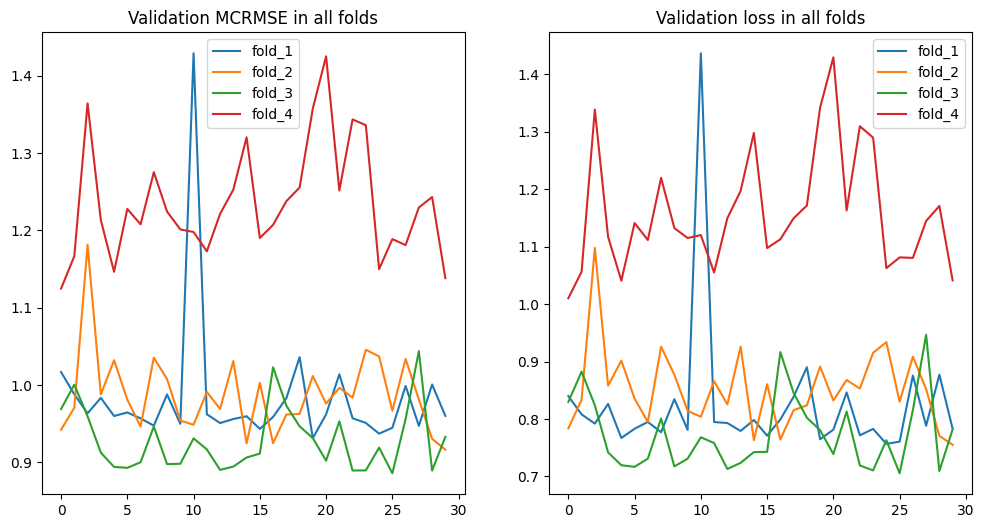

In [78]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

for index in range(1, 5):
    axes[0].plot(fold_data.get(f'fold_{index}').get('valid_metrics'), label=f'fold_{index}')
    axes[0].set_title('Validation MCRMSE in all folds')
    axes[0].legend()

    axes[1].plot(np.mean(fold_data.get(f'fold_{index}').get('valid_all_epoch_losses'), axis=1), label=f'fold_{index}')
    axes[1].set_title('Validation loss in all folds')
    axes[1].legend()


plt.show();

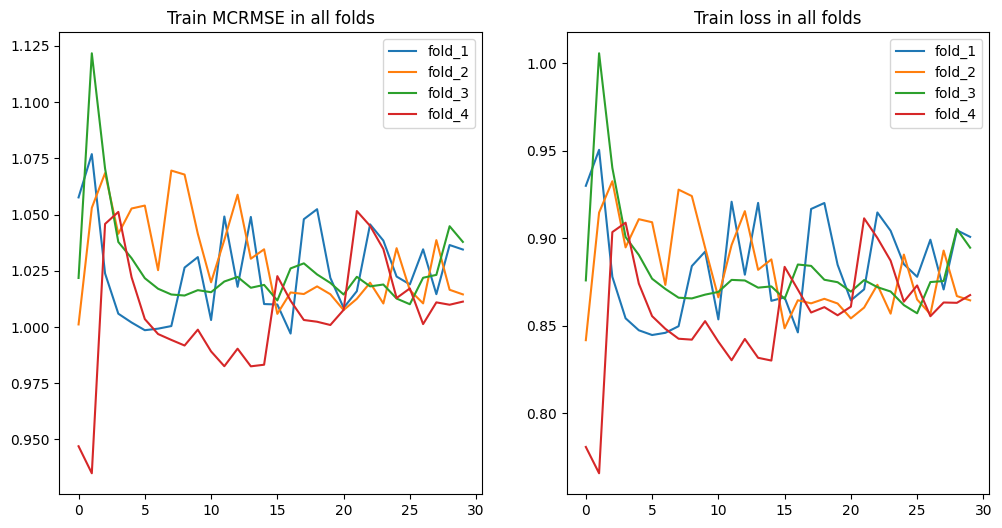

In [79]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

for index in range(1, 5):
    axes[0].plot(fold_data.get(f'fold_{index}').get('train_metrics'), label=f'fold_{index}')
    axes[0].set_title('Train MCRMSE in all folds')
    axes[0].legend()

    axes[1].plot(np.mean(fold_data.get(f'fold_{index}').get('train_all_epoch_losses'), axis=1), label=f'fold_{index}')
    axes[1].set_title('Train loss in all folds')
    axes[1].legend()


plt.show();

In [84]:
import pickle

# Initialize an empty list to store experiment data
experiment_list = []

# Loop through each experiment file
for exp_num in range(1, 6):
    filename = f'experiment_{exp_num}.pickle'
    
    # Check if the file exists
    if os.path.exists(filename):
        # Load data from the pickle file
        with open(filename, 'rb') as file:
            experiment_data = pickle.load(file)
            
        # Extract relevant information from the experiment_data dictionary
        folds_data = experiment_data['folds_data']
        experiment_parameters = experiment_data['experiment_parameters']
        
        for fold_num in range(1, 5):
            fold_data = {
                'experiment': exp_num,
                'fold': fold_num,
                'best_metric': folds_data.get(f'fold_{fold_num}').get('best_metric'),
                'input_size': experiment_parameters['input_size'],
                'hidden_size': experiment_parameters['hidden_size'],
                'num_layers': experiment_parameters['num_layers'],
                'bidirectional': experiment_parameters['bidirectional'],
                'dropout_rate': experiment_parameters['dropout_rate'],
                'rnn_type': experiment_parameters['rnn_type'],
                'average_type': experiment_parameters['average_type'],
                'max_length': experiment_parameters['max_length'],
                'num_epochs': experiment_parameters['num_epochs'],
                'batch_size': experiment_parameters['batch_size'],
                'learning_rate': experiment_parameters['learning_rate'],
                'embedding_model': experiment_parameters['embedding_model']
            }
            experiment_list.append(fold_data)


# Create a pandas DataFrame from the list of experiment information
df = pd.DataFrame(experiment_list)


#### **Experiment results showcase**

In [85]:
df.sort_values('best_metric', ascending=True)

,experiment,fold,best_metric,input_size,hidden_size,num_layers,bidirectional,dropout_rate,rnn_type,average_type,max_length,num_epochs,batch_size,learning_rate,embedding_model
0,1,1,0.599508,300,300,1,False,0.3,<class 'torch.nn.modules.rnn.GRU'>,last,176,15,8,0.001,fasttext
12,4,1,0.616655,300,300,1,False,0.3,<class 'torch.nn.modules.rnn.LSTM'>,last,176,20,8,0.001,fasttext
8,3,1,0.618017,300,300,1,False,0.3,<class 'torch.nn.modules.rnn.GRU'>,last,176,20,8,0.001,fasttext
10,3,3,0.624672,300,300,1,False,0.3,<class 'torch.nn.modules.rnn.GRU'>,last,176,20,8,0.001,fasttext
2,1,3,0.627663,300,300,1,False,0.3,<class 'torch.nn.modules.rnn.GRU'>,last,176,15,8,0.001,fasttext
4,2,1,0.634023,300,300,1,False,0.3,<class 'torch.nn.modules.rnn.GRU'>,last,176,20,16,0.010,fasttext
6,2,3,0.658081,300,300,1,False,0.3,<class 'torch.nn.modules.rnn.GRU'>,last,176,20,16,0.010,fasttext
13,4,2,0.674235,300,300,1,False,0.3,<class 'torch.nn.modules.rnn.LSTM'>,last,176,20,8,0.001,fasttext
5,2,2,0.678685,300,300,1,False,0.3,<class 'torch.nn.modules.rnn.GRU'>,last,176,20,16,0.010,fasttext
1,1,2,0.685234,300,300,1,False,0.3,<class 'torch.nn.modules.rnn.GRU'>,last,176,15,8,0.001,fasttext
